## MCTS-Strength | Relevant Baseline
This notebook aims at providing a neat reusable baseline for training regressors, without any redundant code that may make it harder to understand the key concepts. It surely is not complete nor comprehensive.

Inspired by: 
- https://www.kaggle.com/competitions/um-game-playing-strength-of-mcts-variants/discussion/532341
- https://www.kaggle.com/code/andreasbis/um-mcts-lightgbm-baseline

The key added feature is **split_agent_features** which converts agent names to four categorical features covering their component characteristics.

In [1]:
import os
import sys
import warnings
import pickle
warnings.filterwarnings('ignore')

import numpy as np
import polars as pl
from sklearn.model_selection import KFold
import lightgbm as lgb
from lightgbm import early_stopping, log_evaluation
import catboost

import kaggle_evaluation.mcts_inference_server
from preprocess import *

In [2]:
irrelevant_cols = ['Id', 'Properties', 'Format', 'Time', 'Discrete', 'Realtime', 'Turns', 'Alternating', 'Simultaneous', 'HiddenInformation', 'Match', 'AsymmetricRules', 'AsymmetricPlayRules', 'AsymmetricEndRules', 'AsymmetricSetup', 'Players', 'NumPlayers', 'Simulation', 'Solitaire', 'TwoPlayer', 'Multiplayer', 'Coalition', 'Puzzle', 'DeductionPuzzle', 'PlanningPuzzle', 'Equipment', 'Container', 'Board', 'PrismShape', 'ParallelogramShape', 'RectanglePyramidalShape', 'TargetShape', 'BrickTiling', 'CelticTiling', 'QuadHexTiling', 'Hints', 'PlayableSites', 'Component', 'DiceD3', 'BiasedDice', 'Card', 'Domino', 'Rules', 'SituationalTurnKo', 'SituationalSuperko', 'InitialAmount', 'InitialPot', 'Play', 'BetDecision', 'BetDecisionFrequency', 'VoteDecisionFrequency', 'ChooseTrumpSuitDecision', 'ChooseTrumpSuitDecisionFrequency', 'LeapDecisionToFriend', 'LeapDecisionToFriendFrequency', 'HopDecisionEnemyToFriend', 'HopDecisionEnemyToFriendFrequency', 'HopDecisionFriendToFriend', 'FromToDecisionWithinBoard', 'FromToDecisionBetweenContainers', 'BetEffect', 'BetEffectFrequency', 'VoteEffectFrequency', 'SwapPlayersEffectFrequency', 'TakeControl', 'TakeControlFrequency', 'PassEffectFrequency', 'SetCost', 'SetCostFrequency', 'SetPhase', 'SetPhaseFrequency', 'SetTrumpSuit', 'SetTrumpSuitFrequency', 'StepEffectFrequency', 'SlideEffectFrequency', 'LeapEffectFrequency', 'HopEffectFrequency', 'FromToEffectFrequency', 'SwapPiecesEffect', 'SwapPiecesEffectFrequency', 'ShootEffect', 'ShootEffectFrequency', 'MaxCapture', 'OffDiagonalDirection', 'Information', 'HidePieceType', 'HidePieceOwner', 'HidePieceCount', 'HidePieceRotation', 'HidePieceValue', 'HidePieceState', 'InvisiblePiece', 'End', 'LineDrawFrequency', 'ConnectionDraw', 'ConnectionDrawFrequency', 'GroupLossFrequency', 'GroupDrawFrequency', 'LoopLossFrequency', 'LoopDraw', 'LoopDrawFrequency', 'PatternLoss', 'PatternLossFrequency', 'PatternDraw', 'PatternDrawFrequency', 'PathExtentEndFrequency', 'PathExtentWinFrequency', 'PathExtentLossFrequency', 'PathExtentDraw', 'PathExtentDrawFrequency', 'TerritoryLoss', 'TerritoryLossFrequency', 'TerritoryDraw', 'TerritoryDrawFrequency', 'CheckmateLoss', 'CheckmateLossFrequency', 'CheckmateDraw', 'CheckmateDrawFrequency', 'NoTargetPieceLoss', 'NoTargetPieceLossFrequency', 'NoTargetPieceDraw', 'NoTargetPieceDrawFrequency', 'NoOwnPiecesDraw', 'NoOwnPiecesDrawFrequency', 'FillLoss', 'FillLossFrequency', 'FillDraw', 'FillDrawFrequency', 'ScoringDrawFrequency', 'NoProgressWin', 'NoProgressWinFrequency', 'NoProgressLoss', 'NoProgressLossFrequency', 'SolvedEnd', 'Behaviour', 'StateRepetition', 'PositionalRepetition', 'SituationalRepetition', 'Duration', 'Complexity', 'BoardCoverage', 'GameOutcome', 'StateEvaluation', 'Clarity', 'Narrowness', 'Variance', 'Decisiveness', 'DecisivenessMoves', 'DecisivenessThreshold', 'LeadChange', 'Stability', 'Drama', 'DramaAverage', 'DramaMedian', 'DramaMaximum', 'DramaMinimum', 'DramaVariance', 'DramaChangeAverage', 'DramaChangeSign', 'DramaChangeLineBestFit', 'DramaChangeNumTimes', 'DramaMaxIncrease', 'DramaMaxDecrease', 'MoveEvaluation', 'MoveEvaluationAverage', 'MoveEvaluationMedian', 'MoveEvaluationMaximum', 'MoveEvaluationMinimum', 'MoveEvaluationVariance', 'MoveEvaluationChangeAverage', 'MoveEvaluationChangeSign', 'MoveEvaluationChangeLineBestFit', 'MoveEvaluationChangeNumTimes', 'MoveEvaluationMaxIncrease', 'MoveEvaluationMaxDecrease', 'StateEvaluationDifference', 'StateEvaluationDifferenceAverage', 'StateEvaluationDifferenceMedian', 'StateEvaluationDifferenceMaximum', 'StateEvaluationDifferenceMinimum', 'StateEvaluationDifferenceVariance', 'StateEvaluationDifferenceChangeAverage', 'StateEvaluationDifferenceChangeSign', 'StateEvaluationDifferenceChangeLineBestFit', 'StateEvaluationDifferenceChangeNumTimes', 'StateEvaluationDifferenceMaxIncrease', 'StateEvaluationDifferenceMaxDecrease', 'BoardSitesOccupied', 'BoardSitesOccupiedMinimum', 'BranchingFactor', 'BranchingFactorMinimum', 'DecisionFactor', 'DecisionFactorMinimum', 'MoveDistance', 'MoveDistanceMinimum', 'PieceNumber', 'PieceNumberMinimum', 'ScoreDifference', 'ScoreDifferenceMinimum', 'ScoreDifferenceChangeNumTimes', 'Roots', 'Cosine', 'Sine', 'Tangent', 'Exponential', 'Logarithm', 'ExclusiveDisjunction', 'Float', 'HandComponent', 'SetHidden', 'SetInvisible', 'SetHiddenCount', 'SetHiddenRotation', 'SetHiddenState', 'SetHiddenValue', 'SetHiddenWhat', 'SetHiddenWho']
game_cols = ['GameRulesetName', 'EnglishRules', 'LudRules']
output_cols = ['num_wins_agent1', 'num_draws_agent1', 'num_losses_agent1']
agent_cols = ['agent1', 'agent2']
dropped_cols = output_cols + irrelevant_cols + game_cols

In [3]:
class Config:
    #train_path = 'dataset/train.csv'
    train_path = 'dataset/train.csv'
    
    early_stop = 50
    n_splits = 5
    seed = 1212
    split_agent_features = True
    
    lgbm_params = {
        'num_boost_round': 10_000,
        'seed': 1212,
        'verbose': -1,
        'num_leaves': 63,
        'learning_rate': 0.05,
        'max_depth': 8,
        'reg_lambda': 1.0,
    }

    cat_params1={'task_type'           : "GPU",
                'eval_metric'         : "RMSE",
                'bagging_temperature' : 0.50,
                'iterations'          : 3096,
                'learning_rate'       : 0.08,
                'max_depth'           : 12,
                'l2_leaf_reg'         : 1.25,
                'min_data_in_leaf'    : 24,
                'random_strength'     : 0.25, 
                'verbose'             : 1,
                }
    
    cat_params2={'task_type'           : "GPU",
            'eval_metric'         : "RMSE",
            'bagging_temperature' : 0.60,
            'iterations'          : 3096,
            'learning_rate'       : 0.08,
            'max_depth'           : 12,
            'l2_leaf_reg'         : 1.25,
            'min_data_in_leaf'    : 24,
            'random_strength'     : 0.20, 
            'max_bin'             :2048,
            'verbose'             : 1,
            }
    
    cat_params3={'task_type'           : "GPU",
            'eval_metric'         : "RMSE",
            'bagging_temperature' : 0.60,
            'iterations'          : 2000,
            'learning_rate'       : 0.08,
            'max_depth'           : 12,
            'l2_leaf_reg'         : 1.25,
            'min_data_in_leaf'    : 24,
            'random_strength'     : 0.20, 
            'max_bin'             :2048,
            'verbose'             : 1,
            }
    
    cat_params4={   'task_type'           : "GPU",
                'eval_metric'         : "RMSE",
                'bagging_temperature' : 0.60,
                'iterations'          : 3072,
                'learning_rate'       : 0.08,
                'max_depth'           : 10,
                'l2_leaf_reg'         : 1.25,
                'min_data_in_leaf'    : 20,
                'random_strength'     : 0.20, 
                'max_bin'             :2048,
                'verbose'             : 1,
                }
    
    cat_params5={   'task_type'           : "GPU",
                'eval_metric'         : "RMSE",
                'bagging_temperature' : 0.60,
                'iterations'          : 5072,
                'learning_rate'       : 0.08,
                'max_depth'           : 8,
                'l2_leaf_reg'         : 1.25,
                'min_data_in_leaf'    : 18,
                'random_strength'     : 0.20, 
                'max_bin'             :2048,
                'verbose'             : 1,
                }

In [4]:
def delete_less_freq_col(df, mode='train'):
    column_sums = df.sum(axis=0)
    if mode == 'train':
        column_sums = column_sums.iloc[613:] # only consider the cols with game rule
    else:
        column_sums = column_sums.iloc[612:]

    avg = column_sums.sum()/len(column_sums)
    var = column_sums.var()
    lower_bound = avg-var**(1/2)
    #print('lower bound: {}'.format(lower_bound))

    to_delete_df = column_sums[column_sums < lower_bound]

    selected_cols = to_delete_df.index.to_list()

    processed_df = df.drop(columns=selected_cols)
    return selected_cols, processed_df

# train_df = pl.read_csv('dataset_preprocess/preprocessed_dataset.csv').to_pandas()
# col_to_be_dropped, deleted_dff = delete_less_freq_col(train_df)
# col_to_be_dropped


In [5]:
def process_data(df): 
    df = df.drop(filter(lambda x: x in df.columns, dropped_cols))
    if Config.split_agent_features:
        for col in agent_cols:
            df = df.with_columns(pl.col(col).str.split(by="-").list.to_struct(fields=lambda idx: f"{col}_{idx}")).unnest(col).drop(f"{col}_0")
    df = df.with_columns([pl.col(col).cast(pl.Categorical) for col in df.columns if col[:6] in agent_cols])            
    df = df.with_columns([pl.col(col).cast(pl.Float32) for col in df.columns if col[:6] not in agent_cols])
    print(f'Data shape: {df.shape}')
    return df.to_pandas()

def df_add_adv(df):
    df_processed = process_data(pl.from_pandas(df))
    col_names = df_processed.columns.tolist()[:8]
    with (open('mapping/agent_tables.pkl', 'rb')) as openfile:
        agents_transition_tables = pickle.load(openfile)

    # with (open('mapping/game_table.pkl', 'rb')) as openfile:
    #     game_table = pickle.load(openfile)
    # df_processed['GameRulesetName_adv'] = df['GameRulesetName'].map(game_table).astype(float)

    for col_name in col_names:
        df_processed['{}_adv'.format(col_name)] = df_processed[col_name].map(agents_transition_tables[col_name]).astype(float)
    df_processed = df_processed.drop(columns=['agent1_4_adv', 'agent2_4_adv'])

    # with (open('mapping/game_draw_table.pkl', 'rb')) as openfile:
    #     game_draw_table = pickle.load(openfile)
    # df_processed['GameRulesetName_draw_rate'] = df['GameRulesetName'].map(game_draw_table).astype(float)    

    return df_processed

def double_data(df):
    df = pd.read_csv('dataset/train.csv')
    df2 = df.copy()
    df = df[df['Asymmetric'] == 0].rename(columns={'agent1': 'agent2', 'agent2':'agent1'})
    df['utility_agent1'] = df['utility_agent1'] * -1.
    df = pd.concat([df, df2], ignore_index=True)

    return pl.from_pandas(df)

In [6]:
def train_lgb(data):
    X = data.drop(['utility_agent1'], axis=1)
    y = data['utility_agent1']

    cv = KFold(n_splits=Config.n_splits, shuffle=True, random_state=Config.seed)
    models = []
    for fi, (train_idx, valid_idx) in enumerate(cv.split(X, y)):
        print(f'Fold {fi+1}/{Config.n_splits} ...')
        # model = lgb.LGBMRegressor(**Config.lgbm_params)
        # model.fit(X.iloc[train_idx], y.iloc[train_idx],
        #           eval_set=[(X.iloc[valid_idx], y.iloc[valid_idx])],
        #           eval_metric='rmse',
        #           callbacks=[lgb.early_stopping(Config.early_stop)])
        model = catboost.CatBoostRegressor(**Config.cat_params5, cat_features=data.columns.tolist()[:8])
        model.fit(X.iloc[train_idx], y.iloc[train_idx],
                  eval_set=[(X.iloc[valid_idx], y.iloc[valid_idx])])
        models.append(model)

    with open('models/cat_adv_small.pkl','wb') as f:
        pickle.dump(models,f)

    return models

def infer_lgb(data, models):
    return np.clip(np.mean([model.predict(data) for model in models], axis=0), -1, 1)

In [7]:
train_df = pd.read_csv(Config.train_path)

In [8]:
train_df_2 = df_add_adv(train_df)
#models = train_lgb(process_data(train_df))
models = train_lgb(train_df_2)

Data shape: (233234, 597)
Fold 1/5 ...
0:	learn: 0.6091376	test: 0.6064685	best: 0.6064685 (0)	total: 53.8ms	remaining: 4m 32s
1:	learn: 0.5951837	test: 0.5925508	best: 0.5925508 (1)	total: 105ms	remaining: 4m 25s
2:	learn: 0.5830963	test: 0.5806398	best: 0.5806398 (2)	total: 156ms	remaining: 4m 22s
3:	learn: 0.5728560	test: 0.5703885	best: 0.5703885 (3)	total: 205ms	remaining: 4m 20s
4:	learn: 0.5629020	test: 0.5606631	best: 0.5606631 (4)	total: 258ms	remaining: 4m 21s
5:	learn: 0.5548377	test: 0.5526027	best: 0.5526027 (5)	total: 310ms	remaining: 4m 21s
6:	learn: 0.5470598	test: 0.5449557	best: 0.5449557 (6)	total: 360ms	remaining: 4m 20s
7:	learn: 0.5401206	test: 0.5380288	best: 0.5380288 (7)	total: 411ms	remaining: 4m 20s
8:	learn: 0.5335950	test: 0.5315526	best: 0.5315526 (8)	total: 463ms	remaining: 4m 20s
9:	learn: 0.5278767	test: 0.5257544	best: 0.5257544 (9)	total: 512ms	remaining: 4m 19s
10:	learn: 0.5225044	test: 0.5204060	best: 0.5204060 (10)	total: 570ms	remaining: 4m 22s
1

In [9]:
test_df = pd.read_csv('dataset/test.csv')
test_df = df_add_adv(test_df)

Data shape: (3, 596)


In [9]:
for model in models:
    print(model.best_score_)

{'learn': {'RMSE': 0.07321647771591812}, 'validation': {'RMSE': 0.2473560815393056}}
{'learn': {'RMSE': 0.06666950095904055}, 'validation': {'RMSE': 0.24785671363958164}}
{'learn': {'RMSE': 0.06995204997899111}, 'validation': {'RMSE': 0.24679786090379613}}
{'learn': {'RMSE': 0.07064679299258834}, 'validation': {'RMSE': 0.2494307529166524}}
{'learn': {'RMSE': 0.06917709784481312}, 'validation': {'RMSE': 0.24750921342586352}}


### Submission via the competition API
We follow https://www.kaggle.com/code/sohier/mcts-demo-submission/ \
We add **run_i** global counter to train (or load) models in the first **predict** call, which is not limited to 10 minutes runtime.
    

In [ ]:
run_i = 0
def predict(test_data, submission):
    #print(process_and_save_csv(test_data.to_pandas()).head())
    #print(process_data(test_data).head())
    #print(test_data.to_pandas().columns[-1])

    global run_i, models
    if run_i == 0:
        train_df = pl.read_csv(Config.train_path)
        train_df = double_data(train_df.to_pandas())
        train_df = process_data(train_df)
        #models = train_lgb(process_data(train_df))
        models = train_lgb(train_df.to_pandas())
        # _, train_data = delete_less_freq_col(train_df.to_pandas())
        #train_data = train_df.to_pandas().drop(columns=col_to_be_dropped)
        #models = train_lgb(train_data)
    run_i += 1
    
    #test_data = process_data(test_data)
    #test_data = process_for_test(test_data.to_pandas())
    test_data = process_for_test(test_data.to_pandas())
    test_data = test_data.drop(columns=col_to_be_dropped)
    return submission.with_columns(pl.Series('utility_agent1', infer_lgb(test_data, models)))

inference_server = kaggle_evaluation.mcts_inference_server.MCTSInferenceServer(predict)
if os.getenv('KAGGLE_IS_COMPETITION_RERUN'):
    inference_server.serve()
else:
    inference_server.run_local_gateway(
        (
            'dataset/test.csv',
            'dataset/sample_submission.csv'
        )
    )

Fold 1/5 ...


Traceback (most recent call last):
  File "c:\Users\KO\anaconda3\envs\tf\lib\site-packages\grpc\_server.py", line 552, in _call_behavior
    response_or_iterator = behavior(argument, context)
  File "c:\Users\KO\Desktop\Undergraduate\senior\ML\final project\kaggle_evaluation\core\relay.py", line 294, in Send
    response_payload = _serialize(response_function(*args, **kwargs))
  File "C:\Users\KO\AppData\Local\Temp\ipykernel_8840\1759125113.py", line 11, in predict
    models = train_lgb(train_df.to_pandas())
  File "C:\Users\KO\AppData\Local\Temp\ipykernel_8840\3818325533.py", line 10, in train_lgb
    model.fit(X.iloc[train_idx], y.iloc[train_idx],
  File "c:\Users\KO\anaconda3\envs\tf\lib\site-packages\lightgbm\sklearn.py", line 1189, in fit
    super().fit(
  File "c:\Users\KO\anaconda3\envs\tf\lib\site-packages\lightgbm\sklearn.py", line 955, in fit
    self._Booster = train(
  File "c:\Users\KO\anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py", line 282, in train
    booste

GatewayRuntimeError: (<GatewayRuntimeErrorType.SERVER_RAISED_EXCEPTION: 3>, '<_InactiveRpcError of RPC that terminated with:\n\tstatus = StatusCode.UNKNOWN\n\tdetails = "Exception calling application: pandas dtypes must be int, float or bool.\nFields with bad pandas dtypes: agent2_1: object, agent2_3: object, agent1_1: object, agent1_3: object"\n\tdebug_error_string = "UNKNOWN:Error received from peer  {created_time:"2024-11-29T12:46:30.2888771+00:00", grpc_status:2, grpc_message:"Exception calling application: pandas dtypes must be int, float or bool.\\nFields with bad pandas dtypes: agent2_1: object, agent2_3: object, agent1_1: object, agent1_3: object"}"\n>')

In [ ]:
'''
1. 0.2486413846
2. 0.2483218787
3. 0.2508237708
4. 0.2485561825
5. 0.2474569871
'''

In [10]:
run_i = 0
def predict(test_data, submission):
    #print(process_and_save_csv(test_data.to_pandas()).head())
    #print(process_data(test_data).head())
    #print(test_data.to_pandas().columns[-1])

    with (open('models/cat_deleted_2.pkl', 'rb')) as openfile:
        models = pickle.load(openfile)
    
    #test_data = process_data(test_data)
    test_data = process_for_test(test_data.to_pandas())
    test_data = test_data.drop(columns=col_to_be_dropped)
    
    return submission.with_columns(pl.Series('utility_agent1', infer_lgb(test_data, models)))

inference_server = kaggle_evaluation.mcts_inference_server.MCTSInferenceServer(predict)
if os.getenv('KAGGLE_IS_COMPETITION_RERUN'):
    inference_server.serve()
else:
    inference_server.run_local_gateway(
        (
            'dataset/test.csv',
            'dataset/sample_submission.csv'
        )
    )

In [16]:
def delete_less_freq_col_analysis(df, mode='train'):
    column_sums = df.sum(axis=0)
    if mode == 'train':
        column_sums = column_sums.iloc[613:] # only consider the cols with game rule
    else:
        column_sums = column_sums.iloc[612:]

    avg = column_sums.sum()/len(column_sums)
    var = column_sums.var()
    lower_bound = avg-var**(1/2)

    return lower_bound, column_sums

train_df = pl.read_csv(Config.train_path).to_pandas()
threshold, series = delete_less_freq_col_analysis(train_df)

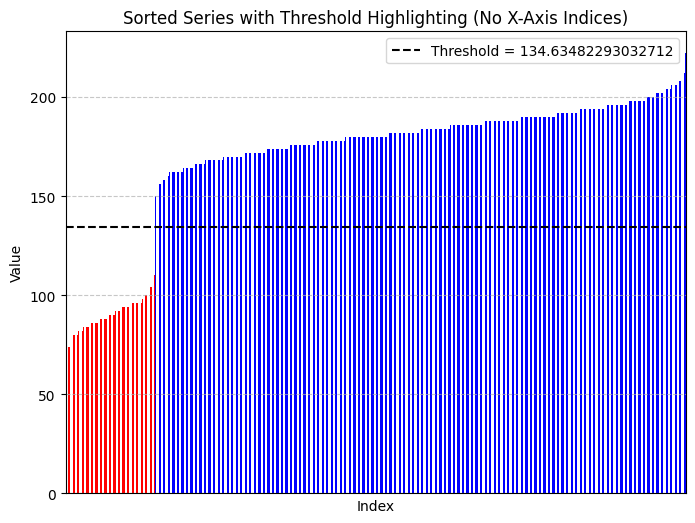

In [18]:
import pandas as pd
import matplotlib.pyplot as plt

# Example data
data = series

# Sort the Series in ascending order
sorted_series = series.sort_values(ascending=True)

# Plot the sorted Series
ax = sorted_series.plot(kind='bar', figsize=(8, 6), color=['red' if value <= threshold else 'blue' for value in sorted_series])

# # Highlight bars below or equal to the threshold
# for idx, value in enumerate(sorted_series):
#     if value <= threshold:
#         ax.text(idx, value + 1, f'{value}', ha='center', color='red', fontsize=10)

# Add the threshold line
plt.axhline(y=threshold, color='black', linestyle='--', label=f'Threshold = {threshold}')

# Disable x-axis indices
ax.set_xticks([])

# Add other plot details
plt.title('Sorted Series with Threshold Highlighting (No X-Axis Indices)')
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# new dataset

In [1]:
import pandas as pd

df = pd.read_csv('dataset/train.csv')
df = df[df['Asymmetric']==0].rename(columns={'agent1': 'agent2', 'agent2':'agent1'})
df['utility_agent1'] = df['utility_agent1'] * -1.

In [23]:
split_values = df['agent1'].copy().str.split('-')
split_values.iloc[2]

['MCTS', 'UCB1', '0.1', 'NST', 'false']

In [26]:
import os

irrelevant_cols = ['Id', 'Properties', 'Format', 'Time', 'Discrete', 'Realtime', 'Turns', 'Alternating', 'Simultaneous', 'HiddenInformation', 'Match', 'AsymmetricRules', 'AsymmetricPlayRules', 'AsymmetricEndRules', 'AsymmetricSetup', 'Players', 'NumPlayers', 'Simulation', 'Solitaire', 'TwoPlayer', 'Multiplayer', 'Coalition', 'Puzzle', 'DeductionPuzzle', 'PlanningPuzzle', 'Equipment', 'Container', 'Board', 'PrismShape', 'ParallelogramShape', 'RectanglePyramidalShape', 'TargetShape', 'BrickTiling', 'CelticTiling', 'QuadHexTiling', 'Hints', 'PlayableSites', 'Component', 'DiceD3', 'BiasedDice', 'Card', 'Domino', 'Rules', 'SituationalTurnKo', 'SituationalSuperko', 'InitialAmount', 'InitialPot', 'Play', 'BetDecision', 'BetDecisionFrequency', 'VoteDecisionFrequency', 'ChooseTrumpSuitDecision', 'ChooseTrumpSuitDecisionFrequency', 'LeapDecisionToFriend', 'LeapDecisionToFriendFrequency', 'HopDecisionEnemyToFriend', 'HopDecisionEnemyToFriendFrequency', 'HopDecisionFriendToFriend', 'FromToDecisionWithinBoard', 'FromToDecisionBetweenContainers', 'BetEffect', 'BetEffectFrequency', 'VoteEffectFrequency', 'SwapPlayersEffectFrequency', 'TakeControl', 'TakeControlFrequency', 'PassEffectFrequency', 'SetCost', 'SetCostFrequency', 'SetPhase', 'SetPhaseFrequency', 'SetTrumpSuit', 'SetTrumpSuitFrequency', 'StepEffectFrequency', 'SlideEffectFrequency', 'LeapEffectFrequency', 'HopEffectFrequency', 'FromToEffectFrequency', 'SwapPiecesEffect', 'SwapPiecesEffectFrequency', 'ShootEffect', 'ShootEffectFrequency', 'MaxCapture', 'OffDiagonalDirection', 'Information', 'HidePieceType', 'HidePieceOwner', 'HidePieceCount', 'HidePieceRotation', 'HidePieceValue', 'HidePieceState', 'InvisiblePiece', 'End', 'LineDrawFrequency', 'ConnectionDraw', 'ConnectionDrawFrequency', 'GroupLossFrequency', 'GroupDrawFrequency', 'LoopLossFrequency', 'LoopDraw', 'LoopDrawFrequency', 'PatternLoss', 'PatternLossFrequency', 'PatternDraw', 'PatternDrawFrequency', 'PathExtentEndFrequency', 'PathExtentWinFrequency', 'PathExtentLossFrequency', 'PathExtentDraw', 'PathExtentDrawFrequency', 'TerritoryLoss', 'TerritoryLossFrequency', 'TerritoryDraw', 'TerritoryDrawFrequency', 'CheckmateLoss', 'CheckmateLossFrequency', 'CheckmateDraw', 'CheckmateDrawFrequency', 'NoTargetPieceLoss', 'NoTargetPieceLossFrequency', 'NoTargetPieceDraw', 'NoTargetPieceDrawFrequency', 'NoOwnPiecesDraw', 'NoOwnPiecesDrawFrequency', 'FillLoss', 'FillLossFrequency', 'FillDraw', 'FillDrawFrequency', 'ScoringDrawFrequency', 'NoProgressWin', 'NoProgressWinFrequency', 'NoProgressLoss', 'NoProgressLossFrequency', 'SolvedEnd', 'Behaviour', 'StateRepetition', 'PositionalRepetition', 'SituationalRepetition', 'Duration', 'Complexity', 'BoardCoverage', 'GameOutcome', 'StateEvaluation', 'Clarity', 'Narrowness', 'Variance', 'Decisiveness', 'DecisivenessMoves', 'DecisivenessThreshold', 'LeadChange', 'Stability', 'Drama', 'DramaAverage', 'DramaMedian', 'DramaMaximum', 'DramaMinimum', 'DramaVariance', 'DramaChangeAverage', 'DramaChangeSign', 'DramaChangeLineBestFit', 'DramaChangeNumTimes', 'DramaMaxIncrease', 'DramaMaxDecrease', 'MoveEvaluation', 'MoveEvaluationAverage', 'MoveEvaluationMedian', 'MoveEvaluationMaximum', 'MoveEvaluationMinimum', 'MoveEvaluationVariance', 'MoveEvaluationChangeAverage', 'MoveEvaluationChangeSign', 'MoveEvaluationChangeLineBestFit', 'MoveEvaluationChangeNumTimes', 'MoveEvaluationMaxIncrease', 'MoveEvaluationMaxDecrease', 'StateEvaluationDifference', 'StateEvaluationDifferenceAverage', 'StateEvaluationDifferenceMedian', 'StateEvaluationDifferenceMaximum', 'StateEvaluationDifferenceMinimum', 'StateEvaluationDifferenceVariance', 'StateEvaluationDifferenceChangeAverage', 'StateEvaluationDifferenceChangeSign', 'StateEvaluationDifferenceChangeLineBestFit', 'StateEvaluationDifferenceChangeNumTimes', 'StateEvaluationDifferenceMaxIncrease', 'StateEvaluationDifferenceMaxDecrease', 'BoardSitesOccupied', 'BoardSitesOccupiedMinimum', 'BranchingFactor', 'BranchingFactorMinimum', 'DecisionFactor', 'DecisionFactorMinimum', 'MoveDistance', 'MoveDistanceMinimum', 'PieceNumber', 'PieceNumberMinimum', 'ScoreDifference', 'ScoreDifferenceMinimum', 'ScoreDifferenceChangeNumTimes', 'Roots', 'Cosine', 'Sine', 'Tangent', 'Exponential', 'Logarithm', 'ExclusiveDisjunction', 'Float', 'HandComponent', 'SetHidden', 'SetInvisible', 'SetHiddenCount', 'SetHiddenRotation', 'SetHiddenState', 'SetHiddenValue', 'SetHiddenWhat', 'SetHiddenWho']
game_cols = ['GameRulesetName', 'EnglishRules', 'LudRules']
output_cols = ['num_wins_agent1', 'num_draws_agent1', 'num_losses_agent1']
agent_cols = ['agent1', 'agent2']
dropped_cols = output_cols + irrelevant_cols + game_cols

def save_agent_data(df, agent_col):

    split_values = df[agent_col].copy().str.split('-')
    max_parts = len(split_values[0])


    for i in range(1, max_parts):
        col_name = f"{agent_col}_part{i+1}"

        l = []
        #print(split_values, split_values[0])
        for j in range(len(split_values)):
            l.append(split_values.iloc[j][i])

        df[col_name] = l
        df = one_hot_encode_column(df, col_name)
    df = df.drop(columns=[agent_col])

    return df

def one_hot_encode_column(df, column_name):
    """
    對指定的列進行one-hot編碼
    """
    one_hot = pd.get_dummies(df[column_name], prefix=column_name, dtype=int)
    df = pd.concat([df, one_hot], axis=1)
    df = df.drop(columns=[column_name])
    return df

def process_and_save_csv_2(df):
    #output_foldername = 'dataset_preprocess'
    output_foldername = 'dataset_preprocess'
    os.makedirs(output_foldername, exist_ok=True)
    
        #df = pd.read_csv('dataset/train.csv')

    for agent_col in ['agent1', 'agent2']:
        if agent_col in df.columns:
            df = save_agent_data(df, agent_col)
        else:
            raise KeyError(f"Missing required column: '{agent_col}'")

    df = one_hot_encode_column(df, 'GameRulesetName')

    df = df.drop(columns=dropped_cols, errors='ignore')

    #print(df.head())
    
    filename = "preprocessed_dataset2.csv"
    filepath = os.path.join(output_foldername, filename)
    df.to_csv(filepath, index=False)
    print(f"Saved: {filepath}")      
    
    return df

process_and_save_csv_2(df)

Saved: dataset_preprocess\preprocessed_dataset2.csv


,Stochastic,Asymmetric,AsymmetricForces,AsymmetricPiecesType,PlayersWithDirections,Cooperation,Team,Shape,SquareShape,HexShape,...,GameRulesetName_Yoin,GameRulesetName_Yote,GameRulesetName_Yovodi,GameRulesetName_Yovodji,GameRulesetName_Yucebao,GameRulesetName_Zamma,GameRulesetName_Zola,GameRulesetName_Zurgaan_Tal,GameRulesetName_Zuz_Mel_5x5,GameRulesetName_Zuz_Mel_7x7
0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
233229,0,0,0,0,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,1
233230,0,0,0,0,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,1
233231,0,0,0,0,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,1
233232,0,0,0,0,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,1


In [27]:
df1 = pd.read_csv('dataset_preprocess/preprocessed_dataset.csv')
df2 = pd.read_csv('dataset_preprocess/preprocessed_dataset2.csv')

df = pd.concat([df1, df2], ignore_index=True)
print(df.head())
df.to_csv('dataset_preprocess/preprocessed_dataset_double_2.csv', index=False)

   Stochastic  Asymmetric  AsymmetricForces  AsymmetricPiecesType  \
0           0           0                 0                     0   
1           0           0                 0                     0   
2           0           0                 0                     0   
3           0           0                 0                     0   
4           0           0                 0                     0   

   PlayersWithDirections  Cooperation  Team  Shape  SquareShape  HexShape  \
0                      0            0     0      1            0         0   
1                      0            0     0      1            0         0   
2                      0            0     0      1            0         0   
3                      0            0     0      1            0         0   
4                      0            0     0      1            0         0   

   ...  GameRulesetName_Yoin  GameRulesetName_Yote  GameRulesetName_Yovodi  \
0  ...                     0                

# new dataset2

In [36]:
def process_data_2(df): 
    df = df.drop(filter(lambda x: x in df.columns, dropped_cols))
    if Config.split_agent_features:
        for col in agent_cols:
            df = df.with_columns(pl.col(col).str.split(by="-").list.to_struct(fields=lambda idx: f"{col}_{idx}")).unnest(col).drop(f"{col}_0")
    print([pl.col(col).cast(pl.Categorical) for col in df.columns if col[:6] in agent_cols])
    df = df.with_columns([pl.col(col).cast(pl.Categorical) for col in df.columns if col[:6] in agent_cols])            
    df = df.with_columns([pl.col(col).cast(pl.Float32) for col in df.columns if col[:6] not in agent_cols])
    print(f'Data shape: {df.shape}')
    return df.to_pandas()

# df = pd.read_csv('dataset/train.csv')
# df2 = df.copy()
# df = df.rename(columns={'agent1': 'agent2', 'agent2':'agent1'})
# df['utility_agent1'] = df['utility_agent1'] * -1.
# df = pd.concat([df, df2], ignore_index=True)

# df.head()

In [17]:
import polars as pl

irrelevant_cols = ['Id', 'Properties', 'Format', 'Time', 'Discrete', 'Realtime', 'Turns', 'Alternating', 'Simultaneous', 'HiddenInformation', 'Match', 'AsymmetricRules', 'AsymmetricPlayRules', 'AsymmetricEndRules', 'AsymmetricSetup', 'Players', 'NumPlayers', 'Simulation', 'Solitaire', 'TwoPlayer', 'Multiplayer', 'Coalition', 'Puzzle', 'DeductionPuzzle', 'PlanningPuzzle', 'Equipment', 'Container', 'Board', 'PrismShape', 'ParallelogramShape', 'RectanglePyramidalShape', 'TargetShape', 'BrickTiling', 'CelticTiling', 'QuadHexTiling', 'Hints', 'PlayableSites', 'Component', 'DiceD3', 'BiasedDice', 'Card', 'Domino', 'Rules', 'SituationalTurnKo', 'SituationalSuperko', 'InitialAmount', 'InitialPot', 'Play', 'BetDecision', 'BetDecisionFrequency', 'VoteDecisionFrequency', 'ChooseTrumpSuitDecision', 'ChooseTrumpSuitDecisionFrequency', 'LeapDecisionToFriend', 'LeapDecisionToFriendFrequency', 'HopDecisionEnemyToFriend', 'HopDecisionEnemyToFriendFrequency', 'HopDecisionFriendToFriend', 'FromToDecisionWithinBoard', 'FromToDecisionBetweenContainers', 'BetEffect', 'BetEffectFrequency', 'VoteEffectFrequency', 'SwapPlayersEffectFrequency', 'TakeControl', 'TakeControlFrequency', 'PassEffectFrequency', 'SetCost', 'SetCostFrequency', 'SetPhase', 'SetPhaseFrequency', 'SetTrumpSuit', 'SetTrumpSuitFrequency', 'StepEffectFrequency', 'SlideEffectFrequency', 'LeapEffectFrequency', 'HopEffectFrequency', 'FromToEffectFrequency', 'SwapPiecesEffect', 'SwapPiecesEffectFrequency', 'ShootEffect', 'ShootEffectFrequency', 'MaxCapture', 'OffDiagonalDirection', 'Information', 'HidePieceType', 'HidePieceOwner', 'HidePieceCount', 'HidePieceRotation', 'HidePieceValue', 'HidePieceState', 'InvisiblePiece', 'End', 'LineDrawFrequency', 'ConnectionDraw', 'ConnectionDrawFrequency', 'GroupLossFrequency', 'GroupDrawFrequency', 'LoopLossFrequency', 'LoopDraw', 'LoopDrawFrequency', 'PatternLoss', 'PatternLossFrequency', 'PatternDraw', 'PatternDrawFrequency', 'PathExtentEndFrequency', 'PathExtentWinFrequency', 'PathExtentLossFrequency', 'PathExtentDraw', 'PathExtentDrawFrequency', 'TerritoryLoss', 'TerritoryLossFrequency', 'TerritoryDraw', 'TerritoryDrawFrequency', 'CheckmateLoss', 'CheckmateLossFrequency', 'CheckmateDraw', 'CheckmateDrawFrequency', 'NoTargetPieceLoss', 'NoTargetPieceLossFrequency', 'NoTargetPieceDraw', 'NoTargetPieceDrawFrequency', 'NoOwnPiecesDraw', 'NoOwnPiecesDrawFrequency', 'FillLoss', 'FillLossFrequency', 'FillDraw', 'FillDrawFrequency', 'ScoringDrawFrequency', 'NoProgressWin', 'NoProgressWinFrequency', 'NoProgressLoss', 'NoProgressLossFrequency', 'SolvedEnd', 'Behaviour', 'StateRepetition', 'PositionalRepetition', 'SituationalRepetition', 'Duration', 'Complexity', 'BoardCoverage', 'GameOutcome', 'StateEvaluation', 'Clarity', 'Narrowness', 'Variance', 'Decisiveness', 'DecisivenessMoves', 'DecisivenessThreshold', 'LeadChange', 'Stability', 'Drama', 'DramaAverage', 'DramaMedian', 'DramaMaximum', 'DramaMinimum', 'DramaVariance', 'DramaChangeAverage', 'DramaChangeSign', 'DramaChangeLineBestFit', 'DramaChangeNumTimes', 'DramaMaxIncrease', 'DramaMaxDecrease', 'MoveEvaluation', 'MoveEvaluationAverage', 'MoveEvaluationMedian', 'MoveEvaluationMaximum', 'MoveEvaluationMinimum', 'MoveEvaluationVariance', 'MoveEvaluationChangeAverage', 'MoveEvaluationChangeSign', 'MoveEvaluationChangeLineBestFit', 'MoveEvaluationChangeNumTimes', 'MoveEvaluationMaxIncrease', 'MoveEvaluationMaxDecrease', 'StateEvaluationDifference', 'StateEvaluationDifferenceAverage', 'StateEvaluationDifferenceMedian', 'StateEvaluationDifferenceMaximum', 'StateEvaluationDifferenceMinimum', 'StateEvaluationDifferenceVariance', 'StateEvaluationDifferenceChangeAverage', 'StateEvaluationDifferenceChangeSign', 'StateEvaluationDifferenceChangeLineBestFit', 'StateEvaluationDifferenceChangeNumTimes', 'StateEvaluationDifferenceMaxIncrease', 'StateEvaluationDifferenceMaxDecrease', 'BoardSitesOccupied', 'BoardSitesOccupiedMinimum', 'BranchingFactor', 'BranchingFactorMinimum', 'DecisionFactor', 'DecisionFactorMinimum', 'MoveDistance', 'MoveDistanceMinimum', 'PieceNumber', 'PieceNumberMinimum', 'ScoreDifference', 'ScoreDifferenceMinimum', 'ScoreDifferenceChangeNumTimes', 'Roots', 'Cosine', 'Sine', 'Tangent', 'Exponential', 'Logarithm', 'ExclusiveDisjunction', 'Float', 'HandComponent', 'SetHidden', 'SetInvisible', 'SetHiddenCount', 'SetHiddenRotation', 'SetHiddenState', 'SetHiddenValue', 'SetHiddenWhat', 'SetHiddenWho']
game_cols = ['GameRulesetName', 'EnglishRules', 'LudRules']
output_cols = ['num_wins_agent1', 'num_draws_agent1', 'num_losses_agent1']
agent_cols = ['agent1', 'agent2']
dropped_cols = output_cols + irrelevant_cols + game_cols

df = process_data_2(pl.from_pandas(df))
df.to_csv('dataset/train_double.csv')

Data shape: (466468, 597)


In [28]:
df = pd.read_csv('dataset/train.csv').iloc[:100, :]

In [31]:
df = pl.from_pandas(df)

In [37]:
process_data_2(df)

[<Expr ['col("agent1_1").strict_cast(Ca…'] at 0x1C536AADA30>, <Expr ['col("agent1_2").strict_cast(Ca…'] at 0x1C536AAD460>, <Expr ['col("agent1_3").strict_cast(Ca…'] at 0x1C536A842E0>, <Expr ['col("agent1_4").strict_cast(Ca…'] at 0x1C536AA8340>, <Expr ['col("agent2_1").strict_cast(Ca…'] at 0x1C3FF7C31C0>, <Expr ['col("agent2_2").strict_cast(Ca…'] at 0x1C402BAE220>, <Expr ['col("agent2_3").strict_cast(Ca…'] at 0x1C402BAEFA0>, <Expr ['col("agent2_4").strict_cast(Ca…'] at 0x1C402BAE1C0>]
Data shape: (100, 597)


,agent1_1,agent1_2,agent1_3,agent1_4,agent2_1,agent2_2,agent2_3,agent2_4,Stochastic,Asymmetric,...,PlayerValue,Efficiency,CopyContext,Then,ForEachPiece,DoLudeme,Trigger,PlayoutsPerSecond,MovesPerSecond,utility_agent1
0,ProgressiveHistory,0.1,MAST,false,ProgressiveHistory,0.6,Random200,false,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,298.070007,18877.169922,-0.466667
1,ProgressiveHistory,0.1,MAST,false,UCB1GRAVE,0.6,NST,true,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,298.070007,18877.169922,-0.333333
2,ProgressiveHistory,0.1,MAST,true,UCB1,0.1,NST,false,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,298.070007,18877.169922,-0.066667
3,ProgressiveHistory,0.1,MAST,true,UCB1,0.6,NST,false,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,298.070007,18877.169922,-0.333333
4,ProgressiveHistory,0.1,MAST,true,UCB1GRAVE,1.41421356237,NST,false,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,298.070007,18877.169922,-0.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,UCB1,1.41421356237,Random200,true,UCB1GRAVE,0.6,NST,false,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,298.070007,18877.169922,-0.333333
96,UCB1GRAVE,0.1,MAST,false,UCB1,0.1,MAST,false,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,298.070007,18877.169922,0.200000
97,UCB1GRAVE,0.1,MAST,false,UCB1,0.1,Random200,false,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,298.070007,18877.169922,-0.066667
98,UCB1GRAVE,0.1,MAST,false,UCB1,0.1,Random200,true,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,298.070007,18877.169922,0.200000


In [ ]:
def double_data(df):
    df = pd.read_csv('dataset/train.csv')
    df2 = df.copy()
    df = df.rename(columns={'agent1': 'agent2', 'agent2':'agent1'})
    df['utility_agent1'] = df['utility_agent1'] * -1.
    df = pd.concat([df, df2], ignore_index=True)

    return pl.from_pandas(df)

df = process_data(pl.from_pandas(df))
df

Data shape: (466468, 597)


,agent2_1,agent2_2,agent2_3,agent2_4,agent1_1,agent1_2,agent1_3,agent1_4,Stochastic,Asymmetric,...,PlayerValue,Efficiency,CopyContext,Then,ForEachPiece,DoLudeme,Trigger,PlayoutsPerSecond,MovesPerSecond,utility_agent1
0,ProgressiveHistory,0.1,MAST,false,ProgressiveHistory,0.6,Random200,false,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,298.070007,18877.169922,0.466667
1,ProgressiveHistory,0.1,MAST,false,UCB1GRAVE,0.6,NST,true,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,298.070007,18877.169922,0.333333
2,ProgressiveHistory,0.1,MAST,true,UCB1,0.1,NST,false,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,298.070007,18877.169922,0.066667
3,ProgressiveHistory,0.1,MAST,true,UCB1,0.6,NST,false,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,298.070007,18877.169922,0.333333
4,ProgressiveHistory,0.1,MAST,true,UCB1GRAVE,1.41421356237,NST,false,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,298.070007,18877.169922,0.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
466463,ProgressiveHistory,1.41421356237,Random200,false,UCB1Tuned,1.41421356237,NST,false,0.0,0.0,...,0.0,1.0,0.0,1.0,1.0,0.0,0.0,157.520004,157174.578125,-0.733333
466464,UCB1,0.6,MAST,false,UCB1Tuned,1.41421356237,Random200,false,0.0,0.0,...,0.0,1.0,0.0,1.0,1.0,0.0,0.0,157.520004,157174.578125,0.266667
466465,UCB1GRAVE,1.41421356237,NST,false,UCB1Tuned,1.41421356237,Random200,false,0.0,0.0,...,0.0,1.0,0.0,1.0,1.0,0.0,0.0,157.520004,157174.578125,0.666667
466466,UCB1GRAVE,1.41421356237,NST,true,UCB1Tuned,1.41421356237,Random200,false,0.0,0.0,...,0.0,1.0,0.0,1.0,1.0,0.0,0.0,157.520004,157174.578125,0.666667


In [12]:
import pandas as pd
df = pd.read_csv('dataset/train.csv')

In [13]:
import polars as pl
df_processed = process_data(pl.from_pandas(df))

Data shape: (233234, 597)


In [31]:
col_names = df_processed.columns.tolist()[:8]

In [ ]:
agents_transition_tables = dict()

for col_name in col_names:
    l = df_processed[col_name].unique().tolist()
    table = dict()
    print('for {}:'.format(col_name))
    for n in l:
        if len(df_processed[df_processed[col_name] == n]) == 0:
            adv = 0
        else:
            adv = df_processed[df_processed[col_name] == n]['utility_agent1'].sum() / len(df_processed[df_processed[col_name] == n])
            table[n] = adv
        print('col: {} category: {}\n\tadvantage: {}'.format(col_name, n, adv))
    agents_transition_tables[col_name] = table
    print('----------------------------------------------------------------------')
for col_name in agents_transition_tables:
    print('table {}: {}'.format(col_name, agents_transition_tables[col_name]))


for agent1_1:
col: agent1_1 category: ProgressiveHistory
	advantage: 0.00823588740404992
col: agent1_1 category: UCB1
	advantage: 0.049384840211508525
col: agent1_1 category: UCB1GRAVE
	advantage: 0.01167076994507145
col: agent1_1 category: UCB1Tuned
	advantage: 0.10773021850887428
----------------------------------------------------------------------
for agent1_2:
col: agent1_2 category: 0.1
	advantage: -0.028171643324703906
col: agent1_2 category: 0.6
	advantage: 0.06605591429868647
col: agent1_2 category: 1.41421356237
	advantage: 0.0955128257266844
----------------------------------------------------------------------
for agent1_3:
col: agent1_3 category: MAST
	advantage: 0.07421244947543525
col: agent1_3 category: NST
	advantage: -0.0011770335200407388
col: agent1_3 category: Random200
	advantage: 0.05982957338989652
----------------------------------------------------------------------
for agent1_4:
col: agent1_4 category: false
	advantage: 0.0416661805508417
col: agent1_4 catego

In [67]:
import pickle 
with open('mapping/agent_tables.pkl','wb') as f:
    pickle.dump(agents_transition_tables,f)

In [46]:
rule_names = df['GameRulesetName'].unique().tolist()

In [ ]:
cnt = 0
game_table = dict()
for rule_name in rule_names:
    if len(df[df['GameRulesetName'] == rule_name]) == 0:
        adv = 0
    else:
        adv = df[df['GameRulesetName'] == rule_name]['utility_agent1'].sum() / len(df[df['GameRulesetName'] == rule_name])
        cnt += 1
        print('for {}:'.format(rule_name))
        print('col: {} \n\tadvantage: {}'.format(rule_name, adv))
        print('----------------------------------------------------------------------')
    game_table[rule_name] = adv

print(cnt)

for 00Y:
col: 00Y 
	advantage: -0.02491582491582491
----------------------------------------------------------------------
for 1D_Chess:
col: 1D_Chess 
	advantage: 0.7558441558441558
----------------------------------------------------------------------
for 20_SquaresSeleucid_Scholarly:
col: 20_SquaresSeleucid_Scholarly 
	advantage: -0.03583333333333334
----------------------------------------------------------------------
for 3D_Tic-Tac-Toe:
col: 3D_Tic-Tac-Toe 
	advantage: 0.6787878787878787
----------------------------------------------------------------------
for 4_Squared:
col: 4_Squared 
	advantage: 0.048611111111111105
----------------------------------------------------------------------
for 58_HolesCarnarvon_and_Carter_D6_Suggested:
col: 58_HolesCarnarvon_and_Carter_D6_Suggested 
	advantage: 0.054545454545454536
----------------------------------------------------------------------
for 58_HolesCarnarvon_and_Carter_Suggested:
col: 58_HolesCarnarvon_and_Carter_Suggested 
	advant

In [96]:
print(game_table)

with open('mapping/game_table.pkl','wb') as f:
    pickle.dump(game_table,f)

{'00Y': -0.02491582491582491, '1D_Chess': 0.7558441558441558, '20_SquaresSeleucid_Scholarly': -0.03583333333333334, '3D_Tic-Tac-Toe': 0.6787878787878787, '4_Squared': 0.048611111111111105, '58_HolesCarnarvon_and_Carter_D6_Suggested': 0.054545454545454536, '58_HolesCarnarvon_and_Carter_Suggested': 0.06356589147286822, '58_HolesCarter_Crossover_1_D4_Suggested': 0.03787878787878787, '58_HolesCarter_Crossover_1_D6_Suggested': 0.0547008547008547, '58_HolesCarter_Crossover_1_Suggested': 0.049305555555555554, '58_HolesCarter_Crossover_2_D4_Suggested': -0.0032520325203252037, '58_HolesCarter_Crossover_2_D6_Suggested': 0.05151515151515151, '58_HolesCarter_Crossover_2_Suggested': 0.07482993197278912, '58_HolesCarter_Crossover_3_D4_Suggested': 0.6900000000000001, '58_HolesCarter_Crossover_3_D6_Suggested': 0.37424242424242427, '58_HolesCarter_Crossover_3_Suggested': 0.7495495495495496, '58_HolesCarter_Crossover_4_D4_Suggested': 0.009523809523809532, '58_HolesCarter_Crossover_4_D6_Suggested': 0.020

In [92]:
df_processed['GameRulesetName_adv'] = df['GameRulesetName'].map(game_table)
df_processed

,Stochastic,Asymmetric,AsymmetricForces,AsymmetricPiecesType,PlayersWithDirections,Cooperation,Team,Shape,SquareShape,HexShape,...,utility_agent1,GameRulesetName_adv,agent1_1_adv,agent1_2_adv,agent1_3_adv,agent1_4_adv,agent2_1_adv,agent2_2_adv,agent2_3_adv,agent2_4_adv
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,-0.466667,-0.024916,0.008236,-0.028172,0.074212,0.041666,0.092134,0.023927,0.031139,0.042495
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,-0.333333,-0.024916,0.008236,-0.028172,0.074212,0.041666,0.069810,0.023927,0.090138,0.046603
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,-0.066667,-0.024916,0.008236,-0.028172,0.074212,0.047564,0.036756,0.115171,0.090138,0.042495
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,-0.333333,-0.024916,0.008236,-0.028172,0.074212,0.047564,0.036756,0.023927,0.090138,0.042495
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,-0.333333,-0.024916,0.008236,-0.028172,0.074212,0.047564,0.069810,-0.006101,0.090138,0.042495
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
233229,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,-0.733333,-0.046624,0.107730,0.095513,-0.001177,0.041666,0.092134,-0.006101,0.031139,0.042495
233230,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.266667,-0.046624,0.107730,0.095513,0.059830,0.041666,0.036756,0.023927,0.012242,0.042495
233231,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.666667,-0.046624,0.107730,0.095513,0.059830,0.041666,0.069810,-0.006101,0.090138,0.042495
233232,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.666667,-0.046624,0.107730,0.095513,0.059830,0.041666,0.069810,-0.006101,0.090138,0.046603


In [86]:
for col_name in col_names:
    #print(agents_transition_tables[col_name])
    df_processed['{}_adv'.format(col_name)] = df_processed[col_name].map(agents_transition_tables[col_name])
df_processed = df_processed.drop(columns=col_names)
df_processed

,Stochastic,Asymmetric,AsymmetricForces,AsymmetricPiecesType,PlayersWithDirections,Cooperation,Team,Shape,SquareShape,HexShape,...,utility_agent1,GameRulesetName_adv,agent1_1_adv,agent1_2_adv,agent1_3_adv,agent1_4_adv,agent2_1_adv,agent2_2_adv,agent2_3_adv,agent2_4_adv
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,-0.466667,-0.024916,0.008236,-0.028172,0.074212,0.041666,0.092134,0.023927,0.031139,0.042495
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,-0.333333,-0.024916,0.008236,-0.028172,0.074212,0.041666,0.069810,0.023927,0.090138,0.046603
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,-0.066667,-0.024916,0.008236,-0.028172,0.074212,0.047564,0.036756,0.115171,0.090138,0.042495
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,-0.333333,-0.024916,0.008236,-0.028172,0.074212,0.047564,0.036756,0.023927,0.090138,0.042495
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,-0.333333,-0.024916,0.008236,-0.028172,0.074212,0.047564,0.069810,-0.006101,0.090138,0.042495
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
233229,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,-0.733333,-0.046624,0.107730,0.095513,-0.001177,0.041666,0.092134,-0.006101,0.031139,0.042495
233230,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.266667,-0.046624,0.107730,0.095513,0.059830,0.041666,0.036756,0.023927,0.012242,0.042495
233231,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.666667,-0.046624,0.107730,0.095513,0.059830,0.041666,0.069810,-0.006101,0.090138,0.042495
233232,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.666667,-0.046624,0.107730,0.095513,0.059830,0.041666,0.069810,-0.006101,0.090138,0.046603


In [22]:
def df_add_adv(df):
    df_processed = process_data(pl.from_pandas(df))
    col_names = df_processed.columns.tolist()[:8]
    with (open('mapping/agent_tables.pkl', 'rb')) as openfile:
        agents_transition_tables = pickle.load(openfile)

    # with (open('mapping/game_table.pkl', 'rb')) as openfile:
    #     game_table = pickle.load(openfile)
    # df_processed['GameRulesetName_adv'] = df['GameRulesetName'].map(game_table).astype(float)

    for col_name in col_names:
        df_processed['{}_adv'.format(col_name)] = df_processed[col_name].map(agents_transition_tables[col_name]).astype(float)
    df_processed = df_processed.drop(columns=col_names+['agent1_4_adv', 'agent2_4_adv'])

    with (open('mapping/game_draw_table.pkl', 'rb')) as openfile:
        game_draw_table = pickle.load(openfile)
    df_processed['GameRulesetName_draw_rate'] = df['GameRulesetName'].map(game_draw_table).astype(float)    

    return df_processed

df_add_adv(df)

Data shape: (233234, 597)


,Stochastic,Asymmetric,AsymmetricForces,AsymmetricPiecesType,PlayersWithDirections,Cooperation,Team,Shape,SquareShape,HexShape,...,PlayoutsPerSecond,MovesPerSecond,utility_agent1,agent1_1_adv,agent1_2_adv,agent1_3_adv,agent2_1_adv,agent2_2_adv,agent2_3_adv,GameRulesetName_draw_rate
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,298.070007,18877.169922,-0.466667,0.008236,-0.028172,0.074212,0.092134,0.023927,0.031139,0.000000
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,298.070007,18877.169922,-0.333333,0.008236,-0.028172,0.074212,0.069810,0.023927,0.090138,0.000000
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,298.070007,18877.169922,-0.066667,0.008236,-0.028172,0.074212,0.036756,0.115171,0.090138,0.000000
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,298.070007,18877.169922,-0.333333,0.008236,-0.028172,0.074212,0.036756,0.023927,0.090138,0.000000
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,298.070007,18877.169922,-0.333333,0.008236,-0.028172,0.074212,0.069810,-0.006101,0.090138,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
233229,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,157.520004,157174.578125,-0.733333,0.107730,0.095513,-0.001177,0.092134,-0.006101,0.031139,0.162602
233230,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,157.520004,157174.578125,0.266667,0.107730,0.095513,0.059830,0.036756,0.023927,0.012242,0.162602
233231,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,157.520004,157174.578125,0.666667,0.107730,0.095513,0.059830,0.069810,-0.006101,0.090138,0.162602
233232,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,157.520004,157174.578125,0.666667,0.107730,0.095513,0.059830,0.069810,-0.006101,0.090138,0.162602


In [19]:
cnt = 0
rule_names = df['GameRulesetName'].unique().tolist()
game_draw_table = dict()

for rule_name in rule_names:
    if len(df[df['GameRulesetName'] == rule_name]) == 0:
        adv = 0
    else:
        sub_df = df[df['GameRulesetName'] == rule_name]
        adv = sub_df['num_draws_agent1'].sum() / (sub_df['num_draws_agent1'] + sub_df['num_wins_agent1'] + sub_df['num_losses_agent1']).sum()
        cnt += 1
        print('for {}:'.format(rule_name))
        print('col: {} \n\tavg. draw: {}'.format(rule_name, adv))
        print('----------------------------------------------------------------------')
    game_draw_table[rule_name] = adv

with (open('mapping/game_draw_table.pkl', 'rb')) as openfile:
    game_draw_table = pickle.dump(openfile)
print(cnt)

for 00Y:
col: 00Y 
	avg. draw: 0.0
----------------------------------------------------------------------
for 1D_Chess:
col: 1D_Chess 
	avg. draw: 0.23461538461538461
----------------------------------------------------------------------
for 20_SquaresSeleucid_Scholarly:
col: 20_SquaresSeleucid_Scholarly 
	avg. draw: 0.0
----------------------------------------------------------------------
for 3D_Tic-Tac-Toe:
col: 3D_Tic-Tac-Toe 
	avg. draw: 0.0
----------------------------------------------------------------------
for 4_Squared:
col: 4_Squared 
	avg. draw: 0.027131782945736434
----------------------------------------------------------------------
for 58_HolesCarnarvon_and_Carter_D6_Suggested:
col: 58_HolesCarnarvon_and_Carter_D6_Suggested 
	avg. draw: 0.0
----------------------------------------------------------------------
for 58_HolesCarnarvon_and_Carter_Suggested:
col: 58_HolesCarnarvon_and_Carter_Suggested 
	avg. draw: 0.0
--------------------------------------------------------

FileNotFoundError: [Errno 2] No such file or directory: 'mapping/game_draw_table.pkl'

In [21]:
with (open('mapping/game_draw_table.pkl', 'wb')) as f:
    pickle.dump(game_draw_table, f)
